<a href="https://colab.research.google.com/github/aminecloud9/PFE/blob/main/NSLKDD_Originaldata_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
pip install git+https://github.com/artemmavrin/focal-loss.git

In [ ]:
pip install focal-loss

Download dataset

In [29]:
#data=pd.read_csv('/content/drive/MyDrive/CICIDS2017_multi_class_StandardScaler_NormalsationResults.csv')
#train_data = pd.read_csv('/content/drive/MyDrive/KDDTrain+.csv', header = None,nrows=1) # read just first line for columns
#columns = train_data.columns.tolist() # get the columns
#cols_to_use = columns[:len(columns)-1] 
train_data=pd.read_csv('/content/drive/MyDrive/KDDTrain+.csv',header=None)
train_data1=pd.read_csv('/content/drive/MyDrive/KDDTrain+.csv',header=None)
train_data = train_data.iloc[:, :-1]# drop the last one
test_data=pd.read_csv('/content/drive/MyDrive/KDDTest+.csv',header=None)
test_data = test_data.iloc[:, :-1]# drop the last one

Data nemerisation

In [30]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
train_data[[1]] = enc.fit_transform(train_data[[1]])
test_data[[1]] = enc.fit_transform(test_data[[1]])

train_data[[2]] = enc.fit_transform(train_data[[2]])
test_data[[2]] = enc.fit_transform(test_data[[2]])

train_data[[3]] = enc.fit_transform(train_data[[3]])
test_data[[3]] = enc.fit_transform(test_data[[3]])

Train and test data formatting

In [31]:
train_X = train_data.values[:,:-1]
train_y = pd.factorize(train_data.values[:,-1])
test_X = test_data.values[:,:-1]
test_y = pd.factorize(test_data.values[:,-1])

Data scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X=scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

In [33]:
train_y[0]

array([0, 0, 1, ..., 0, 1, 0])

Data augmentation

Class=0, n=67343 (3367150.000%)
Class=1, n=45927 (2296350.000%)
Class=2, n=995 (49750.000%)
Class=3, n=11656 (582800.000%)
Class=4, n=52 (2600.000%)


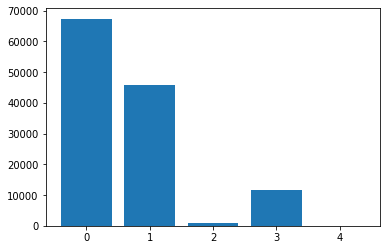

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Counter({0: 67343, 1: 67343, 2: 67343, 3: 67343, 4: 67343})


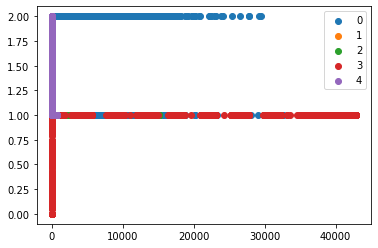

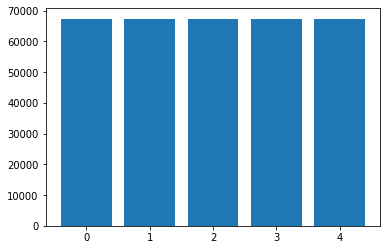

In [34]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# summarize distribution
counter = Counter(train_y[0])
for k,v in counter.items():
	per = v / len(train_y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()
# transform the dataset
oversample = SMOTE()
train_X, train_y = oversample.fit_resample(train_X, train_y[0])
# summarize the new class distribution
counter = Counter(train_y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(train_y == label)[0]
	pyplot.scatter(train_X[row_ix, 0], train_X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

pyplot.bar(counter.keys(), counter.values())
pyplot.show()

reshape input to be [samples, time steps, features]

In [11]:
import keras
#X_train = np.reshape(data.values[:,:-1].astype('float32'), (data.values[:,:-1].shape[0], 1, data.values[:,:-1].shape[1]))
X_train = np.reshape(train_X.astype('float32'), (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X.astype('float32'), (test_X.shape[0], 1, test_X.shape[1]))
#y_train = keras.utils.to_categorical(pd.factorize(data.values[:,77])[0],15)
y_train = keras.utils.to_categorical(train_y[0],5)
y_train = y_train.astype('int')
y_train = np.reshape(y_train,(y_train.shape[0],1,y_train.shape[1]))
y_test = keras.utils.to_categorical(test_y[0],5)
y_test = y_test.astype('int')
y_test = np.reshape(y_test,(y_test.shape[0],1,y_test.shape[1]))

ValueError: ignored

Define the network

In [ ]:
import time
#train_object_num=len(train_data)
#print(test[0])
#model training
batch_size = 1024
model=Sequential()
model.add(LSTM(X_train.shape[2],input_dim=X_train.shape[2],return_sequences=True,kernel_initializer='uniform',activation='relu'))
model.add(LSTM(32,kernel_initializer='uniform',return_sequences=True,activation='relu'))
model.add(LSTM(32,kernel_initializer='uniform',activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(y_train.shape[2],activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='NADAM',metrics=['accuracy'])
model.summary()
start_time = time.time()
history = model.fit(train_X,train_y,validation_split=.3,epochs=100,batch_size=batch_size,verbose=1)
finish_time = time.time() - start_time
model.save("/content/drive/My Drive/model_NSL-KDD_scaled_Multiclass_valsplit.3_bs1024_100ep.h5")

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
loss, accuracy = model.evaluate(X_test,y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
y_pred = model.predict_classes(X_test)
target_names = ['Normal', 'Dos', 'Probe','R2L', 'U2R']
print(classification_report(y_true = np.transpose(test_y[0]), y_pred = y_pred))
#print(accuracy_score(y_true = np.transpose(test_y[0]), y_pred = y_pred))
print("execution time :  ",finish_time)

In [ ]:
s= np.transpose(test_y[0])
s.shape

saving model

In [ ]:
model.save("/content/drive/MyDrive/NSL-KDD_42norm_results_5Dense_po_Dropout_200epoch_1024batch_model.h5")

In [26]:
from keras.models import load_model
#model = load_model('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_model.hdf5')
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

#print("--- %s seconds ---",finish_time)
y_pred = model.predict(X_train)
#np.savetxt('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_predicted.txt', np.transpose([y_test,y_pred]), fmt='%s')

705/705 [==============================] - 3s 5ms/step - loss: 13.0358 - accuracy: 0.0556

Loss: 13.04, Accuracy: 5.56%


In [ ]:
y_pred

In [ ]:
42 col pca 80% : b_s=256 epochs= 300 Lstm(32,32)->Dense(256,128,64,ytrain.shape(2))   ->   accuracy = 62.8%


24 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 83.73%
24 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 40.28%
42 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 48.52%
42 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 45.22%


In [ ]:
# focal loss with multi label
def focal_loss(classes_num, gamma=2., alpha=.25, e=0.1):
    # classes_num contains sample number of each classes
    def focal_loss_fixed(target_tensor, prediction_tensor):
        '''
        prediction_tensor is the output tensor with shape [None, 100], where 100 is the number of classes
        target_tensor is the label tensor, same shape as predcition_tensor
        '''
        #1# get focal loss with no balanced weight which presented in paper function (4)
        zeros = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        one_minus_p = array_ops.where(np.max(target_tensor,zeros), target_tensor - prediction_tensor, zeros)
        FT = -1 * (one_minus_p ** gamma) * tf.log(tf.clip_by_value(prediction_tensor, 1e-8, 1.0))

        #2# get balanced weight alpha
        classes_weight = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)

        total_num = float(sum(classes_num))
        classes_w_t1 = [ total_num / ff for ff in classes_num ]
        sum_ = sum(classes_w_t1)
        classes_w_t2 = [ ff/sum_ for ff in classes_w_t1 ]   #scale
        classes_w_tensor = tf.convert_to_tensor(classes_w_t2, dtype=prediction_tensor.dtype)
        classes_weight += classes_w_tensor

        #alpha = array_ops.where(tf.greater(np.array(target_tensor, dtype=np.float32), zeros), classes_weight, zeros)

        #3# get balanced focal loss
        balanced_fl = alpha * FT
        balanced_fl = tf.reduce_mean(balanced_fl)

        #4# add other op to prevent overfit
        # reference : https://spaces.ac.cn/archives/4493
        nb_classes = len(classes_num)
        fianal_loss = (1-e) * balanced_fl + e * K.categorical_crossentropy(K.ones_like(prediction_tensor)/nb_classes, prediction_tensor)

        return fianal_loss
    return focal_loss_fixed

In [ ]:
def focal_loss(classes_num, gamma=2., alpha=.25, e=0.1):
  def focal_loss_fixed(target_tensor, prediction_tensor):
    tot_num = sum(classes_num)
    alpha = classes_num/tot_num
    mask = np.eye(alpha.shape[1])
    loss = (prediction_tensor*mask - target_tensor*mask)*(prediction_tensor*mask - target_tensor*mask)
    fianal_loss = sum(alpha*loss)
    return fianal_loss
return focal_loss_fixed

In [ ]:
batch_size= 1024
lrate = 0.1
model = Sequential()
model.add(Dense(X_train.shape[2], input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1024, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(768, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(512, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(256, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(128, input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.1))
model.add(Dense(y_train.shape[2], activation='softmax'))
	# compile model
opt = SGD(lr=lrate)
#loss = categorical_focal_loss([67343,45927,995,11656,52])
model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(X_train, y_train, validation_split=.3,batch_size=batch_size, epochs=100, verbose=1)

Epoch 1/100
231/231 [==============================] - 41s 174ms/step - loss: 1.1655 - accuracy: 0.8542 - val_loss: 4.9693 - val_accuracy: 0.3308
Epoch 2/100
231/231 [==============================] - 40s 173ms/step - loss: 0.0537 - accuracy: 0.9849 - val_loss: 3.8741 - val_accuracy: 0.3315
Epoch 3/100
231/231 [==============================] - 40s 173ms/step - loss: 0.0400 - accuracy: 0.9883 - val_loss: 3.4240 - val_accuracy: 0.3302
Epoch 4/100
231/231 [==============================] - 40s 173ms/step - loss: 0.0315 - accuracy: 0.9900 - val_loss: 3.0065 - val_accuracy: 0.5339
Epoch 5/100
231/231 [==============================] - 40s 174ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 3.0195 - val_accuracy: 0.3495
Epoch 6/100
231/231 [==============================] - 40s 173ms/step - loss: 0.0268 - accuracy: 0.9917 - val_loss: 2.9106 - val_accuracy: 0.3885
Epoch 7/100
231/231 [==============================] - 40s 173ms/step - loss: 0.0250 - accuracy: 0.9924 - val_loss: 2.4625 -

Text(0.5, 1.0, 'lrate=0.1')

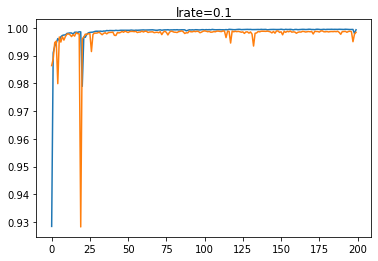

In [ ]:
from matplotlib import pyplot
# plot accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)


Text(0.5, 1.0, 'lrate=0.1')

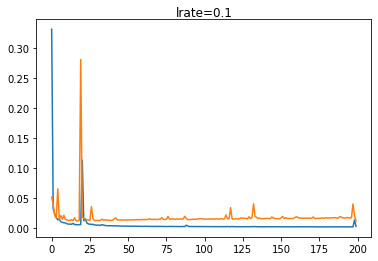

In [ ]:

# plot leoss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)